In [1]:
import os
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime
# os.environ['NUMBA_DISABLE_JIT'] = '1'  # uncomment this if you want to use pypfopt within simulation
from numba import njit

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import base_optimizer

import vectorbt as vbt
from vectorbt.generic.nb import nanmean_nb
from vectorbt.portfolio.nb import create_order_nb, auto_call_seq_ctx_nb
from vectorbt.portfolio.enums import SizeType, Direction

In [2]:
# Define params
symbols = ['FB', 'AMZN', 'NFLX', 'GOOG', 'AAPL']
start_date = datetime(2017, 1, 1)
end_date = datetime.now()
num_tests = 2000

vbt.settings.returns['year_freq'] = '252 days'

In [3]:
ohlcv_by_symbol = vbt.utils.data.download(symbols, start=start_date, end=end_date)

print(ohlcv_by_symbol.keys())

dict_keys(['FB', 'AMZN', 'NFLX', 'GOOG', 'AAPL'])


In [5]:
ohlcv = vbt.utils.data.concat_symbols(ohlcv_by_symbol)

print(ohlcv.keys())

dict_keys(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'])


In [6]:
price = ohlcv['Close']

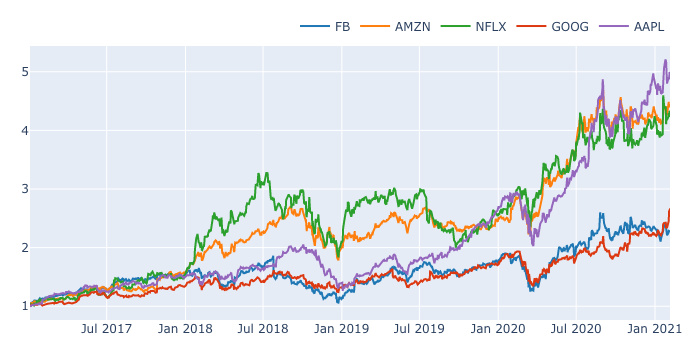

In [7]:
# Plot normalized price series
(price / price.iloc[0]).vbt.plot().show_png()

In [8]:
returns = price.pct_change()

In [9]:
print(returns.mean())

symbol
FB      0.001039
AMZN    0.001635
NFLX    0.001743
GOOG    0.001110
AAPL    0.001760
dtype: float64


In [10]:
print(returns.std())

symbol
FB      0.021427
AMZN    0.019261
NFLX    0.025417
GOOG    0.017704
AAPL    0.019990
dtype: float64


In [11]:
print(returns.corr())

symbol        FB      AMZN      NFLX      GOOG      AAPL
symbol                                                  
FB      1.000000  0.631897  0.500641  0.694848  0.617582
AMZN    0.631897  1.000000  0.638451  0.674875  0.640650
NFLX    0.500641  0.638451  1.000000  0.539611  0.485479
GOOG    0.694848  0.674875  0.539611  1.000000  0.665551
AAPL    0.617582  0.640650  0.485479  0.665551  1.000000


## vectorbt: Random search

### One-time allocation

In [11]:
np.random.seed(42)

# Generate random weights, n times
weights = []
for i in range(num_tests):
    w = np.random.random_sample(len(symbols))
    w = w / np.sum(w)
    weights.append(w)

print(len(weights))

2000


In [12]:
# Build column hierarchy such that one weight corresponds to one price series
_price = price.vbt.tile(num_tests, keys=pd.Index(np.arange(num_tests), name='symbol_group'))
_price = _price.vbt.stack_index(pd.Index(np.concatenate(weights), name='weights'))

print(_price.columns)

MultiIndex([( 0.13319702814025883,    0,   'FB'),
            ( 0.33810081711389406,    0, 'AMZN'),
            ( 0.26031768763785473,    0, 'NFLX'),
            (  0.2128998389048247,    0, 'GOOG'),
            ( 0.05548462820316767,    0, 'AAPL'),
            ( 0.06528491964469331,    1,   'FB'),
            ( 0.02430844330237927,    1, 'AMZN'),
            (  0.3625014516740258,    1, 'NFLX'),
            (  0.2515713061862386,    1, 'GOOG'),
            ( 0.29633387919266296,    1, 'AAPL'),
            ...
            (  0.2056564359049325, 1998,   'FB'),
            ( 0.14846396871443943, 1998, 'AMZN'),
            ( 0.21512097636364197, 1998, 'NFLX'),
            (  0.3738566007394396, 1998, 'GOOG'),
            (0.056902018277546554, 1998, 'AAPL'),
            ( 0.25860265182212094, 1999,   'FB'),
            (  0.2706191852849979, 1999, 'AMZN'),
            (  0.2854538191129893, 1999, 'NFLX'),
            ( 0.11985160754099378, 1999, 'GOOG'),
            (  0.0654727362388982,

In [13]:
# Define order size
size = np.full_like(_price, np.nan)
size[0, :] = np.concatenate(weights)  # allocate at first timestamp, do nothing afterwards

print(size.shape)

(1031, 10000)


**NOTE:** Do not attempt to run the following simulation with Numba disabled.

In [14]:
%%time
# Run simulation
portfolio = vbt.Portfolio.from_orders(
    close=_price,
    size=size,
    size_type='targetpercent',
    group_by='symbol_group',
    cash_sharing=True,
    freq='D',
    incl_unrealized=True
) # all weights sum to 1, no shorting, and 100% investment in risky assets

print(len(portfolio.orders))

10000
CPU times: user 440 ms, sys: 46.3 ms, total: 486 ms
Wall time: 491 ms


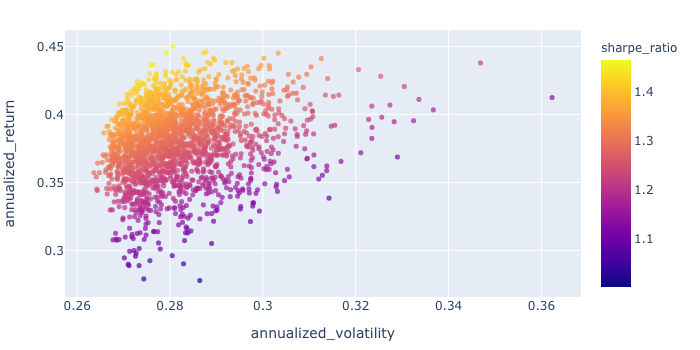

In [15]:
# Plot annualized return against volatility, color by sharpe ratio
annualized_return = portfolio.annualized_return()
annualized_return.index = portfolio.annualized_volatility()
annualized_return.vbt.scatterplot(
    trace_kwargs=dict(
        mode='markers', 
        marker=dict(
            color=portfolio.sharpe_ratio(),
            colorbar=dict(
                title='sharpe_ratio'
            ),
            size=5,
            opacity=0.7
        )
    ),
    xaxis_title='annualized_volatility',
    yaxis_title='annualized_return'
).show_png()

In [16]:
# Get index of the best group according to the target metric
best_symbol_group = portfolio.sharpe_ratio().idxmax()

print(best_symbol_group)

1920


In [17]:
# Print best weights
print(weights[best_symbol_group])

[0.01154842 0.46529877 0.10296527 0.02644507 0.39374246]


In [18]:
# Compute default stats
print(portfolio.iloc[best_symbol_group].stats())

Start                            2017-01-03 00:00:00
End                              2021-02-05 00:00:00
Duration                          1031 days 00:00:00
Init. Cash                                       100
Total Profit                                 357.242
Total Return [%]                             357.242
Benchmark Return [%]                         274.226
Position Coverage [%]                            100
Max. Drawdown [%]                            34.4419
Avg. Drawdown [%]                            2.93988
Max. Drawdown Duration             324 days 00:00:00
Avg. Drawdown Duration    13 days 05:13:02.608695652
Num. Trades                                        5
Win Rate [%]                                     100
Best Trade [%]                               398.035
Worst Trade [%]                               129.42
Avg. Trade [%]                               274.226
Max. Trade Duration               1030 days 00:00:00
Avg. Trade Duration               1030 days 00

### Rebalance monthly

In [19]:
# Select the first index of each month
rb_mask = ~_price.index.to_period('m').duplicated()

print(rb_mask.sum())

50


In [20]:
rb_size = np.full_like(_price, np.nan)
rb_size[rb_mask, :] = np.concatenate(weights)  # allocate at mask

print(rb_size.shape)

(1031, 10000)


**NOTE:** Do not attempt to run the following simulation with Numba disabled.

In [21]:
%%time

# Run simulation, with rebalancing monthly
rb_portfolio = vbt.Portfolio.from_orders(
    close=_price,
    size=rb_size,
    size_type='targetpercent',
    group_by='symbol_group',
    cash_sharing=True,
    call_seq='auto',  # important: sell before buy
    freq='D',
    incl_unrealized=True
)

print(len(rb_portfolio.orders))

499993
CPU times: user 500 ms, sys: 40.3 ms, total: 541 ms
Wall time: 544 ms


In [22]:
rb_best_symbol_group = portfolio.sharpe_ratio().idxmax()

print(rb_best_symbol_group)

1920


In [23]:
print(weights[rb_best_symbol_group])

[0.01154842 0.46529877 0.10296527 0.02644507 0.39374246]


In [24]:
print(rb_portfolio.iloc[rb_best_symbol_group].stats())

Start                             2017-01-03 00:00:00
End                               2021-02-05 00:00:00
Duration                           1031 days 00:00:00
Init. Cash                                        100
Total Profit                                  376.316
Total Return [%]                              376.316
Benchmark Return [%]                          274.226
Position Coverage [%]                             100
Max. Drawdown [%]                             33.6883
Avg. Drawdown [%]                             2.83032
Max. Drawdown Duration              304 days 00:00:00
Avg. Drawdown Duration     12 days 06:29:11.351351351
Num. Trades                                       114
Win Rate [%]                                  99.1228
Best Trade [%]                                249.176
Worst Trade [%]                              -7.13426
Avg. Trade [%]                                65.8767
Max. Trade Duration                1030 days 00:00:00
Avg. Trade Duration       53

In [26]:
def plot_allocation(rb_portfolio):
    # Plot weights development of the portfolio
    rb_holding_value = rb_portfolio.holding_value(group_by=False)
    rb_value = rb_portfolio.value()
    rb_idxs = np.flatnonzero((rb_portfolio.share_flow() != 0).any(axis=1))
    (rb_holding_value.vbt / rb_value).vbt.plot(
        trace_names=symbols,
        trace_kwargs=dict(
            stackgroup='one'
        ),
        shapes=[dict(
            xref='x',
            yref='paper',
            x0=date,
            x1=date,
            y0=0,
            y1=1,
            line_color=vbt.settings.layout['template']['layout']['plot_bgcolor']
        ) for date in price.index[rb_idxs]]
    ).show_png()

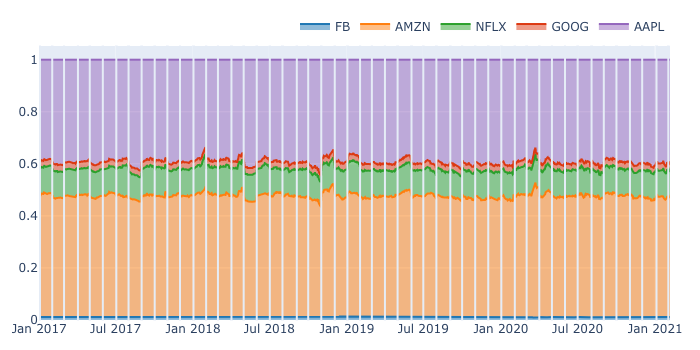

In [26]:
plot_allocation(rb_portfolio.iloc[rb_best_symbol_group])  # best group

### Search and rebalance every 30 days

Utilize low-level API to dynamically search for best Sharpe ratio and rebalance accordingly. Compared to previous method, we won't utilize stacking, but do search in a loop instead. We also will use days instead of months, as latter may contain a various number of trading days.

In [20]:
srb_sharpe = np.full(price.shape[0], np.nan)

@njit
def prep_func_nb(simc, every_nth):
    # Define rebalancing days
    simc.active_mask[:, :] = False
    simc.active_mask[every_nth::every_nth, :] = True
    return ()

@njit
def find_weights_nb(sc, price, num_tests):
    # Find optimal weights based on best Sharpe ratio
    returns = (price[1:] - price[:-1]) / price[:-1]
    returns = returns[1:, :]  # cannot compute np.cov with NaN
    mean = nanmean_nb(returns)
    cov = np.cov(returns, rowvar=False)  # masked arrays not supported by Numba (yet)
    best_sharpe_ratio = -np.inf
    
    for i in range(num_tests):
        # Generate weights
        w = np.random.random_sample(sc.group_len)
        w = w / np.sum(w)
        
        # Compute annualized mean, covariance, and Sharpe ratio
        p_return = np.sum(mean * w) * ann_factor
        p_std = np.sqrt(np.dot(w.T, np.dot(cov, w))) * np.sqrt(ann_factor)
        sharpe_ratio = p_return / p_std
        if sharpe_ratio > best_sharpe_ratio:
            best_sharpe_ratio = sharpe_ratio
            weights = w
            
    return best_sharpe_ratio, weights

@njit
def segment_prep_func_nb(sc, find_weights_nb, history_len, ann_factor, num_tests, srb_sharpe):
    if history_len == -1:
        # Look back at the entire time period
        close = sc.close[:sc.i, sc.from_col:sc.to_col]
    else:
        # Look back at a fixed time period
        if sc.i - history_len <= 0:
            return (np.full(sc.group_len, np.nan),)  # insufficient data
        close = sc.close[sc.i - history_len:sc.i, sc.from_col:sc.to_col]
    
    # Find optimal weights
    best_sharpe_ratio, weights = find_weights_nb(sc, close, num_tests)
    srb_sharpe[sc.i] = best_sharpe_ratio
        
    # Update valuation price and reorder orders
    size_type = np.full(sc.group_len, SizeType.TargetPercent)
    direction = np.full(sc.group_len, Direction.LongOnly)
    temp_float_arr = np.empty(sc.group_len, dtype=np.float_)
    for k in range(sc.group_len):
        col = sc.from_col + k
        sc.last_val_price[col] = sc.close[sc.i, col]
    auto_call_seq_ctx_nb(sc, weights, size_type, direction, temp_float_arr)
    
    return (weights,)

@njit
def order_func_nb(oc, weights):
    col_i = oc.call_seq_now[oc.call_idx]
    return create_order_nb(
        size=weights[col_i], 
        size_type=SizeType.TargetPercent, 
        price=oc.close[oc.i, oc.col]
    )

In [21]:
ann_factor = returns.vbt.returns(freq='D').ann_factor

In [37]:
%%time
# Run simulation using a custom order function
srb_portfolio = vbt.Portfolio.from_order_func(
    price,
    order_func_nb,
    prep_func_nb=prep_func_nb,
    prep_args=(30,),
    segment_prep_func_nb=segment_prep_func_nb,
    segment_prep_args=(find_weights_nb, -1, ann_factor, num_tests, srb_sharpe),
    cash_sharing=True, 
    group_by=True,
    freq='D',
    incl_unrealized=True,
    seed=42
)

CPU times: user 85.6 ms, sys: 2.52 ms, total: 88.1 ms
Wall time: 104 ms


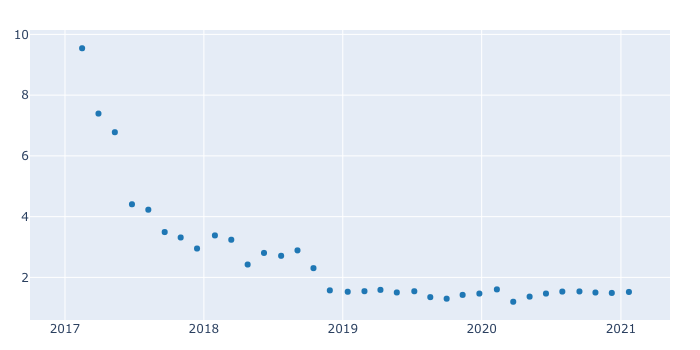

In [30]:
# Plot best Sharpe ratio at each rebalancing day
pd.Series(srb_sharpe, index=price.index).vbt.scatterplot(trace_kwargs=dict(mode='markers')).show_png()

In [31]:
print(srb_portfolio.stats())

Start                             2017-01-03 00:00:00
End                               2021-02-05 00:00:00
Duration                           1031 days 00:00:00
Init. Cash                                        100
Total Profit                                  213.654
Total Return [%]                              213.654
Benchmark Return [%]                          274.226
Position Coverage [%]                         97.0902
Max. Drawdown [%]                             34.3509
Avg. Drawdown [%]                             3.30605
Max. Drawdown Duration              311 days 00:00:00
Avg. Drawdown Duration     15 days 04:19:40.327868852
Num. Trades                                        91
Win Rate [%]                                  80.2198
Best Trade [%]                                77.0805
Worst Trade [%]                              -23.7438
Avg. Trade [%]                                14.2463
Max. Trade Duration                1000 days 00:00:00
Avg. Trade Duration       52

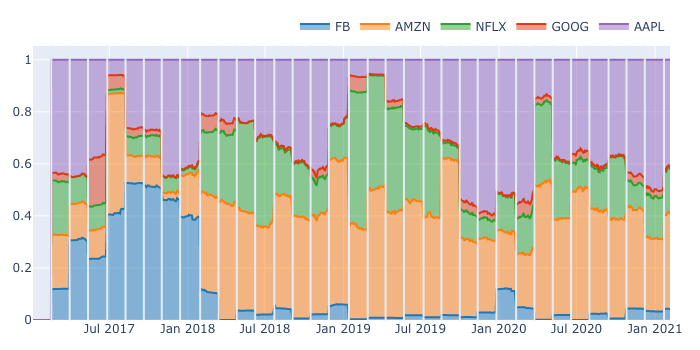

In [32]:
plot_allocation(srb_portfolio)

You can see how weights stabilize themselves with growing data.

In [33]:
%%time
# Run simulation, but now consider only the last 252 days of data
srb252_sharpe = np.full(price.shape[0], np.nan)

srb252_portfolio = vbt.Portfolio.from_order_func(
    price,
    order_func_nb,
    prep_func_nb=prep_func_nb,
    prep_args=(30,),
    segment_prep_func_nb=segment_prep_func_nb,
    segment_prep_args=(find_weights_nb, 252, ann_factor, num_tests, srb252_sharpe),
    cash_sharing=True, 
    group_by=True,
    freq='D',
    incl_unrealized=True,
    seed=42
)

CPU times: user 51.4 ms, sys: 1.21 ms, total: 52.6 ms
Wall time: 53.2 ms


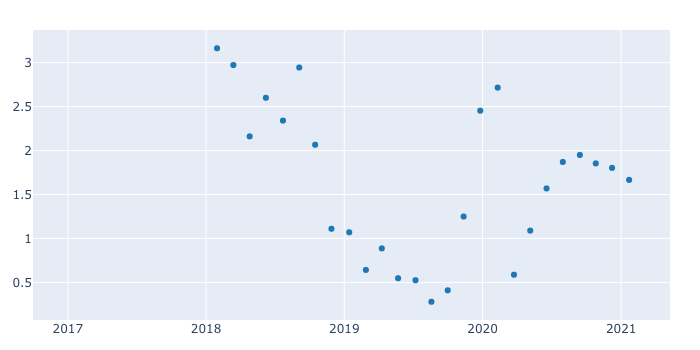

In [34]:
pd.Series(srb252_sharpe, index=price.index).vbt.scatterplot(trace_kwargs=dict(mode='markers')).show_png()

In [35]:
print(srb252_portfolio.stats())

Start                             2017-01-03 00:00:00
End                               2021-02-05 00:00:00
Duration                           1031 days 00:00:00
Init. Cash                                        100
Total Profit                                  132.863
Total Return [%]                              132.863
Benchmark Return [%]                          274.226
Position Coverage [%]                         73.8118
Max. Drawdown [%]                              33.136
Avg. Drawdown [%]                             4.22363
Max. Drawdown Duration              193 days 00:00:00
Avg. Drawdown Duration     16 days 07:38:10.909090909
Num. Trades                                        61
Win Rate [%]                                  72.1311
Best Trade [%]                                89.0979
Worst Trade [%]                              -15.5016
Avg. Trade [%]                                11.4349
Max. Trade Duration                 760 days 00:00:00
Avg. Trade Duration       44

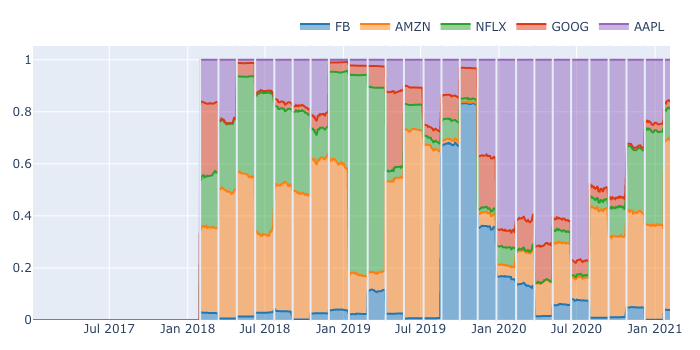

In [36]:
plot_allocation(srb252_portfolio)

A much more volatile weight distribution.

## PyPortfolioOpt + vectorbt

### One-time allocation

In [12]:
# Calculate expected returns and sample covariance amtrix
avg_returns = expected_returns.mean_historical_return(price)
cov_mat = risk_models.sample_cov(price)

# Get weights maximizing the Sharpe ratio
ef = EfficientFrontier(avg_returns, cov_mat)
weights = ef.max_sharpe()
clean_weights = ef.clean_weights()
pyopt_weights = np.array([clean_weights[symbol] for symbol in symbols])

print(pyopt_weights)

[0.      0.40827 0.04964 0.      0.54209]


In [13]:
pyopt_size = np.full_like(price, np.nan)
pyopt_size[0, :] = pyopt_weights  # allocate at first timestamp, do nothing afterwards

print(pyopt_size.shape)

(1031, 5)


In [14]:
%%time
# Run simulation with weights from PyPortfolioOpt
pyopt_portfolio = vbt.Portfolio.from_orders(
    close=price,
    size=pyopt_size,
    size_type='targetpercent',
    group_by=True,
    cash_sharing=True,
    freq='D',
    incl_unrealized=True
)

print(len(pyopt_portfolio.orders))

3
CPU times: user 154 ms, sys: 9.88 ms, total: 164 ms
Wall time: 147 ms


Faster than stacking solution, but doesn't let you compare weights.

In [15]:
print(pyopt_portfolio.stats())

Start                     2017-01-03 00:00:00
End                       2021-02-05 00:00:00
Duration                   1031 days 00:00:00
Init. Cash                                100
Total Profit                          373.014
Total Return [%]                      373.014
Benchmark Return [%]                  274.226
Position Coverage [%]                      60
Max. Drawdown [%]                     34.8417
Avg. Drawdown [%]                     2.64072
Max. Drawdown Duration      294 days 00:00:00
Avg. Drawdown Duration       11 days 12:00:00
Num. Trades                                 3
Win Rate [%]                              100
Best Trade [%]                        398.035
Worst Trade [%]                       332.026
Avg. Trade [%]                        358.279
Max. Trade Duration        1030 days 00:00:00
Avg. Trade Duration        1030 days 00:00:00
Expectancy                            124.338
SQN                                    2.1396
Gross Exposure                    

### Search and rebalance monthly

**NOTE:** PyPortfolioOpt cannot run within Numba, so restart the notebook and disable Numba in the first cell.

In [16]:
def pyopt_find_weights(sc, price, num_tests):
    # Calculate expected returns and sample covariance matrix
    price = pd.DataFrame(price, columns=symbols)
    avg_returns = expected_returns.mean_historical_return(price)
    cov_mat = risk_models.sample_cov(price)

    # Get weights maximizing the Sharpe ratio
    ef = EfficientFrontier(avg_returns, cov_mat)
    weights = ef.max_sharpe()
    clean_weights = ef.clean_weights()
    weights = np.array([clean_weights[symbol] for symbol in symbols])
    best_sharpe_ratio = base_optimizer.portfolio_performance(weights, avg_returns, cov_mat)[2]
            
    return best_sharpe_ratio, weights

In [22]:
%%time
pyopt_srb_sharpe = np.full(price.shape[0], np.nan)

# Run simulation with a custom order function (Numba should be disabled)
pyopt_srb_portfolio = vbt.Portfolio.from_order_func(
    price,
    order_func_nb,
    prep_func_nb=prep_func_nb,
    prep_args=(30,),
    segment_prep_func_nb=segment_prep_func_nb,
    segment_prep_args=(pyopt_find_weights, -1, ann_factor, num_tests, pyopt_srb_sharpe),
    cash_sharing=True, 
    group_by=True,
    freq='D',
    incl_unrealized=True,
    seed=42
)

CPU times: user 716 ms, sys: 12.5 ms, total: 729 ms
Wall time: 790 ms


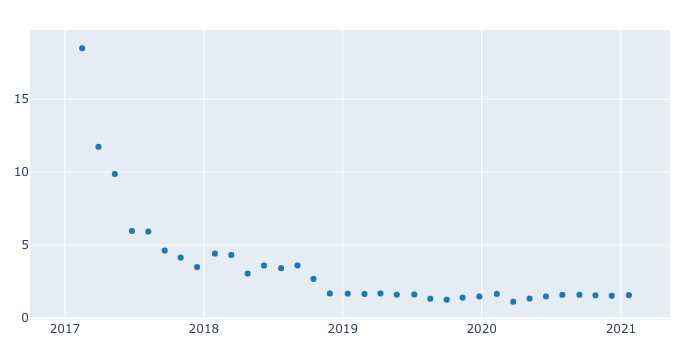

In [23]:
pd.Series(pyopt_srb_sharpe, index=price.index).vbt.scatterplot(trace_kwargs=dict(mode='markers')).show_png()

In [24]:
print(pyopt_srb_portfolio.stats())

Start                             2017-01-03 00:00:00
End                               2021-02-05 00:00:00
Duration                           1031 days 00:00:00
Init. Cash                                        100
Total Profit                                  183.479
Total Return [%]                              183.479
Benchmark Return [%]                          274.226
Position Coverage [%]                         57.6722
Max. Drawdown [%]                             35.3639
Avg. Drawdown [%]                             3.63738
Max. Drawdown Duration              348 days 00:00:00
Avg. Drawdown Duration     16 days 19:42:51.428571428
Num. Trades                                        58
Win Rate [%]                                  84.4828
Best Trade [%]                                68.4189
Worst Trade [%]                              -30.6354
Avg. Trade [%]                                17.2885
Max. Trade Duration                 790 days 00:00:00
Avg. Trade Duration       24

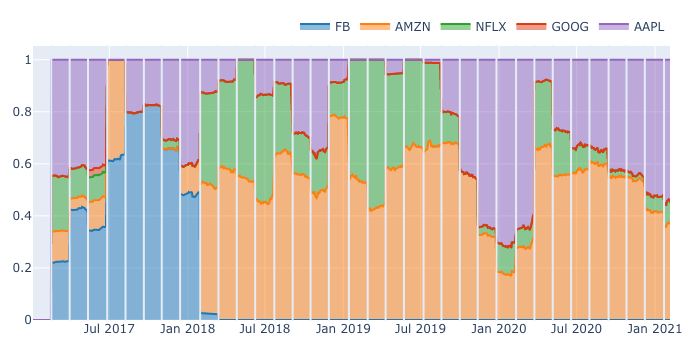

In [27]:
plot_allocation(pyopt_srb_portfolio)